# scHOT and BASiCs consistency analysis

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
import matplotlib as mpl
import scipy.stats as stats


In [67]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [68]:
def concordance(x, y, log=False):
    nonnan = np.isfinite(x) & np.isfinite(y)
#     return stats.spearmanr(x[nonnan],y[nonnan])[0]
    
    if log:
        a = np.log(x)
        b = np.log(y)
    else:
        a = x
        b = y
    cond = np.isfinite(a) & np.isfinite(b)
    a = a[cond]
    b = b[cond]
    cmat = np.cov(a, b)
    return 2*cmat[0,1]/(cmat[0,0] + cmat[1,1] + (a.mean()-b.mean())**2)

In [69]:
result_path = '/data_volume/memento/simulation/acc_fpr/downsampled/'

In [70]:
rates = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
num_replicates = 1
# rates = [1.0, 0.3]

### Variability

In [71]:
schot_full = pd.read_csv(result_path + 'scHOT_downsampled_1.0_0.csv')

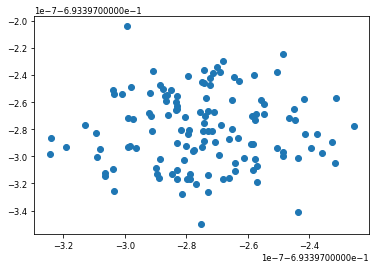

In [64]:
schot_concordances_df = []
for replicate in range(0, num_replicates):
    for rate in rates:

        schot_sub = pd.read_csv(result_path + 'scHOT_downsampled_{}_{}.csv'.format(rate, replicate))

        schot_concordances_df.append((replicate, rate, concordance(schot_full['globalHigherOrderFunction'], schot_sub['globalHigherOrderFunction'])))

schot_concordances_df = pd.DataFrame(schot_concordances_df, columns=['rep', 'rate', 'concordance'])

In [36]:
schot_concordances = schot_concordances_df.groupby('rate').concordance.mean()
schot_concordances_err = schot_concordances_df.groupby('rate').concordance.std()

In [37]:
schot_concordances

rate
0.1   -0.069506
0.2    0.465793
0.3    0.337721
0.4    0.220430
0.5    0.158681
0.6    0.271606
0.7    0.562416
0.8    0.379999
0.9    0.524100
1.0    1.000000
Name: concordance, dtype: float64

### Basics

In [76]:
basics_concordances_df = []
for replicate in range(num_replicates):


    full = pd.read_csv(result_path + 'BASiCS_downsampled_delta_1.0_{}.csv'.format(replicate)).mean(axis=0)
#     stim_full = pd.read_csv(result_path + 'BASiCS_downsampled_delta_stim_1.0_{}.csv'.format(replicate)).mean(axis=0)
    es_full = np.log(full)
    for rate in rates:

        sub = pd.read_csv(result_path + 'BASiCS_downsampled_delta_{}_{}.csv'.format(rate, replicate)).mean(axis=0)
#         stim_ = pd.read_csv(result_path + 'BASiCS_downsampled_delta_stim_{}_{}.csv'.format(rate, replicate)).mean(axis=0)
        es_sub = np.log(sub)

        basics_concordances_df.append((rate, replicate, concordance(es_full, es_sub)))
basics_concordances_df = pd.DataFrame(basics_concordances_df, columns=['rate', 'replicate', 'concordance'])

In [97]:
basics_concordances = basics_concordances_df.groupby('rate').concordance.mean().sort_values(ascending=False)
basics_concordances_err = basics_concordances_df.groupby('rate').concordance.std()

In [98]:
basics_concordances

rate
1.0    1.000000
0.9    0.999450
0.8    0.998849
0.7    0.998196
0.6    0.996139
0.5    0.994940
0.4    0.989667
0.3    0.987174
0.2    0.970267
0.1    0.935965
Name: concordance, dtype: float64

### Memento

In [99]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento
import scipy.sparse as sparse

In [100]:
memento_concordances_df = []
naive_concordances = []
for replicate in range(num_replicates):
    
    adata_full = sc.read(result_path + 'downsampled_1.0_{}.h5ad'.format(replicate))
    adata_full.X = sparse.csr_matrix(adata_full.X.astype(float))
    adata_full.obs['q'] = 0.07
    memento.setup_memento(adata_full, q_column='q', trim_percent=0.1)
    memento.create_groups(adata_full, label_columns=['stim_indicator'])
    memento.compute_1d_moments(adata_full, min_perc_group=.0)
    es_full = np.log(adata_full.uns['memento']['1d_moments']['sg^1'][1])
    
    norm_adata_full = sc.read(result_path + 'downsampled_1.0_{}_norm.h5ad'.format(replicate))
    naive_full = np.log(np.var(norm_adata_full.X, axis=1))

    for rate in rates:
        df = pd.DataFrame()
        adata_sub = sc.read(result_path + 'downsampled_{}_{}.h5ad'.format(rate, replicate))
        adata_sub.X = sparse.csr_matrix(adata_sub.X.astype(float))
        adata_sub.obs['q'] = 0.07*rate
        memento.setup_memento(adata_sub, q_column='q', trim_percent=0.1)
        memento.create_groups(adata_sub, label_columns=['stim_indicator'])
        memento.compute_1d_moments(adata_sub, min_perc_group=.0)

        es_sub = np.log(adata_sub.uns['memento']['1d_moments']['sg^1'][1])
        gene_filter = np.array([g in adata_sub.var.index for g in adata_full.var.index])
        memento_concordances_df.append((rate, replicate, concordance(es_full[gene_filter], es_sub)))
        
        norm_adata_sub = sc.read(result_path + 'downsampled_{}_{}_norm.h5ad'.format(rate, replicate))
        naive_sub = np.log(np.var(norm_adata_sub.X, axis=1))
        naive_concordances.append(concordance(naive_full, naive_sub))
    
memento_concordances_df = pd.DataFrame(memento_concordances_df, columns=['rate', 'replicate', 'concordance'])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWa

In [101]:
memento_concordances = memento_concordances_df.groupby('rate').concordance.mean().sort_values(ascending=False)
memento_concordances_err = memento_concordances_df.groupby('rate').concordance.std()

In [102]:
memento_concordances

rate
1.0    1.000000
0.9    0.999887
0.8    0.999809
0.7    0.999724
0.6    0.999270
0.5    0.999203
0.4    0.998319
0.3    0.996034
0.2    0.990193
0.1    0.959816
Name: concordance, dtype: float64

In [103]:
memento_concordances_df['method'] = 'memento'
basics_concordances_df['method'] = 'BASiCS'
schot_concordances_df['method'] = 'scHOT'


(0.7, 1.03)

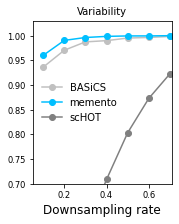

In [118]:
plt.figure(figsize=(2.5,3))
plt.plot(np.array(rates), basics_concordances, '-o',color='silver', label='BASiCS')
plt.plot(np.array(rates), memento_concordances, '-o',color='deepskyblue', label='memento')
plt.plot(np.array(rates), naive_concordances, '-o',color='grey', label='scHOT')
plt.legend(frameon=False)
# plt.ylabel('Concordance to\nfull data')
plt.xlabel('Downsampling rate')
# plt.savefig('method_concordance.png', bbox_inches='tight', dpi=300)
plt.title('Variability')
plt.xlim(0.05, 0.71)
plt.ylim(0.7, 1.03)

### Correlation

In [8]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento
import scipy.sparse as sparse

In [9]:
num_replicates=1

In [119]:
num_replicates = 10
memento_concordances_df = []
spearman_concordances = []
for replicate in range(num_replicates):
    
    adata_full = sc.read(result_path + 'downsampled_1.0_{}.h5ad'.format(replicate))
    adata_full.X = sparse.csr_matrix(adata_full.X.astype(float))
    adata_full.obs['q'] = 0.07
    memento.setup_memento(adata_full, q_column='q', trim_percent=0.035)
    memento.create_groups(adata_full, label_columns=['stim_indicator'])
    memento.compute_1d_moments(adata_full, min_perc_group=.0)
    pairs = np.array(adata_full.var.index.tolist())[:-1].reshape(-1, 2)
    memento.compute_2d_moments(adata_full, gene_pairs=pairs)
    es_full = adata_full.uns['memento']['2d_moments']['sg^1']['corr']
    
    norm_adata_full = sc.read(result_path + 'downsampled_1.0_{}_norm.h5ad'.format(replicate))
    naive_full = np.array([stats.spearmanr(norm_adata_full[:, g1].X.reshape(-1),norm_adata_full[:, g2].X.reshape(-1))[0] for g1, g2 in pairs])

    for rate in rates:
        df = pd.DataFrame()
        adata_sub = sc.read(result_path + 'downsampled_{}_{}.h5ad'.format(rate, replicate))
        adata_sub.X = sparse.csr_matrix(adata_sub.X.astype(float))
        adata_sub.obs['q'] = 0.07*rate
        memento.setup_memento(adata_sub, q_column='q', trim_percent=0.035)
        memento.create_groups(adata_sub, label_columns=['stim_indicator'])
        memento.compute_1d_moments(adata_sub, min_perc_group=.0)
        pair_filter = np.array([g1 in adata_sub.var.index and g2 in adata_sub.var.index for g1, g2 in pairs])
        memento.compute_2d_moments(adata_sub, gene_pairs=pairs[pair_filter])
        es_sub = adata_sub.uns['memento']['2d_moments']['sg^1']['corr']
        memento_concordances_df.append((rate, replicate, concordance(es_full[pair_filter], es_sub)))
        
        norm_adata_sub = sc.read(result_path + 'downsampled_{}_{}_norm.h5ad'.format(rate, replicate))
        naive_sub = np.array([stats.spearmanr(norm_adata_sub[:, g1].X.reshape(-1),norm_adata_sub[:, g2].X.reshape(-1))[0] for g1, g2 in pairs])
        
        naive_concordances.append(concordance(naive_full, naive_sub))
        
#         normed_adata_sub = sc.read(result_path + 'downsampled_{}_{}_norm.h5ad'.format(rate, replicate))
#         normed_adata_sub_ctrl = normed_adata_sub[normed_adata_sub.obs['stim']=='ctrl']
#         normed_adata_sub_stim = normed_adata_sub[normed_adata_sub.obs['stim']=='stim']
#         spearman_es_sub = np.array([
#             stats.spearmanr(normed_adata_sub_stim[:, g1].X.reshape(-1),normed_adata_sub_stim[:, g2].X.reshape(-1))[0] for g1, g2 in pairs])
#         spearman_concordances.append(concordance(spearman_es_full, spearman_es_sub))
        
#         plt.figure()
#         plt.scatter(es_full, es_sub)
#         plt.scatter(spearman_es_full, spearman_es_sub)
#         plt.plot([-1, 1], [-1, 1])
#         print('spearman', concordance(spearman_es_full, spearman_es_sub))
        
    
memento_concordances_df = pd.DataFrame(memento_concordances_df, columns=['rate', 'replicate', 'concordance'])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWa

In [120]:
memento_concordances = memento_concordances_df.groupby('rate').concordance.mean().sort_values(ascending=False)
memento_concordances_err = memento_concordances_df.groupby('rate').concordance.std()

ValueError: x and y must have same first dimension, but have shapes (10,) and (110,)

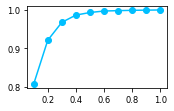

In [121]:
plt.figure(figsize=(2.5,1.5))

# plt.plot(rates, basics_concordances, '-o')
plt.plot(rates, memento_concordances, '-o', color='deepskyblue', label='memento')
plt.plot(rates, naive_concordances, '-o', color='grey', label='scHOT')
# plt.legend()
# plt.ylabel('Concordance to\nfull data')
plt.xlabel('Subsampling rate')
# plt.savefig('method_concordance_corr.png', bbox_inches='tight', dpi=300)
plt.title('Correlation')


### Mean

In [62]:
ctrl_full = pd.read_csv(result_path + 'mu_0.8_ctrl.csv').median(axis=0)
stim_full = pd.read_csv(result_path + 'mu_0.8_stim.csv').median(axis=0)
es_full = np.log(stim_full/ctrl_full)

In [63]:
rates = [0.1, 0.2, 0.4, 0.6]

In [64]:
df_list = []
basics_concordances = []
for rate in rates:
    df = pd.DataFrame()
    ctrl_sub = pd.read_csv(result_path + 'mu_{}_ctrl.csv'.format(rate)).median(axis=0)
    stim_sub = pd.read_csv(result_path + 'mu_{}_stim.csv'.format(rate)).median(axis=0)
    es_sub = np.log(stim_sub/ctrl_sub)
    
    print(concordance(es_full, es_sub))
    df['diff'] = np.abs(es_sub-es_full)
    df['rate'] = rate
    df_list.append(df)
    basics_concordances.append(concordance(es_full, es_sub))
df = pd.concat(df_list)

0.9929708141321044
0.9954224270353301
0.9984086021505373
0.9986420890937018


In [65]:
data_path = '/data_volume/memento/simulation/acc_fpr/'

In [66]:
adata_full = sc.read(data_path + 'subsampled_0.8.h5ad')

In [67]:
adata_full.X = sparse.csr_matrix(adata_full.X.astype(float))

In [68]:
adata_full.obs['q'] = 0.15

In [69]:
memento.setup_memento(adata_full, q_column='q', trim_percent=0.1)

Version 0.0.6


In [70]:
memento.create_groups(adata_full, label_columns=['stim'])
memento.compute_1d_moments(adata_full, min_perc_group=.0)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [71]:
# memento.ht_1d_moments(
#     adata_full, 
#     formula_like='1 + stim',
#     treatment_col='stim', 
#     num_boot=500, 
#     verbose=1,
#     num_cpus=14,
#     resampling='bootstrap',
#     approx=False)

In [72]:
es_full = np.log(adata_full.uns['memento']['1d_moments']['sg^stim'][0]/adata_full.uns['memento']['1d_moments']['sg^ctrl'][0])

In [73]:
df_list = []
memento_concordances = []
for rate in rates:
    df = pd.DataFrame()
    adata_sub = sc.read(data_path + 'subsampled_{}.h5ad'.format(rate))
    adata_sub.X = sparse.csr_matrix(adata_sub.X.astype(float))
    adata_sub.obs['q'] = 0.07
    memento.setup_memento(adata_sub, q_column='q', trim_percent=0.1)
    memento.create_groups(adata_sub, label_columns=['stim'])
    memento.compute_1d_moments(adata_sub, min_perc_group=.0)
    
#     memento.ht_1d_moments(
#         adata_sub, 
#         formula_like='1 + stim',
#         treatment_col='stim', 
#         num_boot=500, 
#         verbose=1,
#         num_cpus=14,
#         resampling='bootstrap',
#         approx=False)
        
#     es_sub = memento.get_1d_ht_result(adata_sub)[['gene','dv_coef']]
    es_sub = np.log(adata_sub.uns['memento']['1d_moments']['sg^stim'][0]/adata_sub.uns['memento']['1d_moments']['sg^ctrl'][0])
#     merged = es_full.merge(es_sub, on='gene')
#     print(concordance(merged['dv_coef_x'], merged['dv_coef_y']))
    print(concordance(es_full, es_sub))
    memento_concordances.append(concordance(es_full, es_sub))
    df['diff'] = np.abs(es_sub-es_full)
    df['rate'] = rate
    df_list.append(df)
    
df = pd.concat(df_list)

Version 0.0.6
0.9935791090629797
Version 0.0.6
0.996116743471582
Version 0.0.6
0.9984761904761904
Version 0.0.6
0.998943164362519


Text(0.5, 1.0, 'Mean')

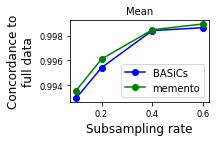

In [74]:
plt.figure(figsize=(2.5,1.5))

plt.plot(rates, basics_concordances, '-o', color='blue')
plt.plot(rates, memento_concordances, '-o', color='green')
plt.legend(['BASiCs','memento', ])
plt.ylabel('Concordance to\nfull data')
plt.xlabel('Subsampling rate')
plt.savefig('method_concordance_mean.png', bbox_inches='tight', dpi=300)
plt.title('Mean')
